In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import torchvision
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import glob as gb
import torch
import torchvision
from torchmetrics.detection import MeanAveragePrecision
from sklearn.preprocessing import LabelEncoder

In [ ]:
#run twice to get /kaggle/input/road-sign-detection path
import kagglehub
path = kagglehub.dataset_download("andrewmvd/road-sign-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/road-sign-detection


#Preprocessing

<Axes: ylabel='Count'>

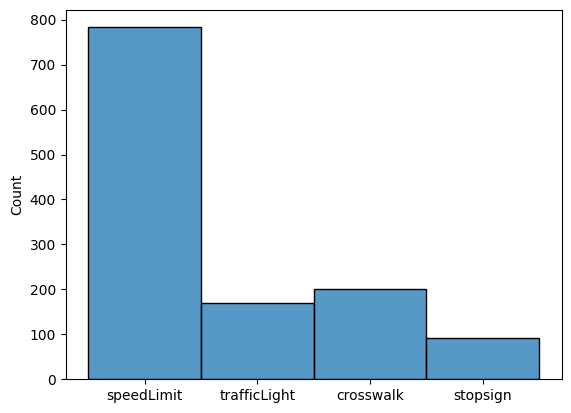

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
labelDict={1:'crosswalk',2:'speedLimit',3:'stopsign',4:'trafficLight'}
roadLabelDict={'crosswalk':1,'speedlimit':2,'stop':3,'trafficlight':4}
roadsignDF=pd.DataFrame(columns=['filename','width','height','objects'])
for anno in os.listdir("/kaggle/input/road-sign-detection/annotations"):
  df=pd.DataFrame(columns=['filename','width','height','objects'])
  anno_path="/kaggle/input/road-sign-detection/annotations/"+anno
  root = ET.parse(anno_path).getroot()
  objects=[]
  for object in root.findall("./object"):
        objects.append({
        'name':object.find("./name").text,
        'pose':object.find("./pose").text,
        'truncated':object.find("./truncated").text,
        'difficult':object.find("./difficult").text,
        'xmin':int(object.find("./bndbox/xmin").text),
        'ymin':int(object.find("./bndbox/ymin").text),
        'xmax':int(object.find("./bndbox/xmax").text),
        'ymax':int(object.find("./bndbox/ymax").text)
        })

  roadsignDF=pd.concat([roadsignDF,pd.DataFrame([[
      "/kaggle/input/road-sign-detection/images/"+anno[:-3]+'png',
      int(root.find("./size/width").text),
      int(root.find("./size/height").text),
      objects
      ]],columns=roadsignDF.columns)],ignore_index=True)
for objects in roadsignDF['objects']:
  for object in objects:
    object['name']=roadLabelDict[object['name']]
for j in range(len(roadsignDF['objects'])):
    for i in range(len(roadsignDF['objects'][j])):
      roadsignDF['objects'][j][i]=[roadsignDF['objects'][j][i]['name'],roadsignDF['objects'][j][i]['xmin'],roadsignDF['objects'][j][i]['ymin'],roadsignDF['objects'][j][i]['xmax'],roadsignDF['objects'][j][i]['ymax']]
roadsignDF.to_pickle("/content/drive/MyDrive/itcs5154/dataset/roadsignDF.pickle")
sns.histplot([labelDict[roadsignDF['objects'][j][i][0]] for j in range(len(roadsignDF['objects'])) for i in range(len(roadsignDF['objects'][j]))])

In [ ]:
roadsignDF=pd.read_pickle("/content/drive/MyDrive/itcs5154/dataset/roadsignDF.pickle")
roadsignDF[['width','height','objects']]=roadsignDF[['width','height','objects']]
roadImgBoxes=roadsignDF['filename']
roadTruths=roadsignDF[['width','height','objects']]
roadLabelDict={1:'crosswalk',2:'speed',3:'stopsign',4:'trafficLight'}
xRoadTrain, xRoadTest, yRoadTrain, yRoadTest= train_test_split(roadImgBoxes,roadTruths, train_size = 0.85)
len(yRoadTrain),len(yRoadTest)

(745, 132)

In [ ]:

import PIL
import random as rand
from sklearn.utils import class_weight
#preprocessing methods
IMG_SIZE= 320
BATCH_SIZE= 20
BUFFER_SIZE = 1000

def processBoxMask(mask,padding=(0,0)):
  indices=tf.where(mask==1)
  TL=tf.reduce_min(indices,axis=0).numpy()
  BR=tf.reduce_max(indices,axis=0).numpy()
  return [TL[1].item()-padding[0],TL[0].item()-padding[0],BR[1].item()+padding[1],BR[0].item()+padding[1]]

def mapFunc(img,truths,training):
    #label, xmin, ymin, xmax, ymax
    vertses=[]
    boxes=[]
    truth=[]
    img=tf.cast(tf.image.resize(tf.image.decode_png(tf.io.read_file(img),channels=3),(IMG_SIZE,IMG_SIZE)),tf.float32)/255
    img=tf.convert_to_tensor(img)
    for obj in truths[2]:
      box=np.zeros((truths[1],truths[0]))
      box[obj[2]:obj[4],obj[1]:obj[3]]=1
      box=PIL.Image.fromarray(box)
      box=box.resize((IMG_SIZE,IMG_SIZE))
      box=np.expand_dims(box,axis=-1)
      box=tf.convert_to_tensor(box)
      box=tf.cast(box,tf.float32)
      boxes.append(box)
      truth.append(obj[0])
    if(training):
      seed=(np.random.randint(0,100000),np.random.randint(0,100000))
      if(rand.randint(0,3)==1):
        img=tf.image.flip_left_right(img)
        for i in range(len(boxes)):
          boxes[i]=tf.image.flip_left_right(boxes[i])
      img=tf.image.stateless_random_brightness(img,max_delta=0.1,seed=seed)
      img=tf.image.stateless_random_contrast(img,lower=0.9,upper=1.1,seed=seed)
    for box in boxes:
      verts=processBoxMask(box,(1,1))
      vertses.append(verts)
    return img,boxes,vertses,truth
def preprocessSets(imgs,truths,training,addFlipped):
    processedImgs=[]
    processedTruths=[]
    processedVerts=[]
    processedBoxes=[]
    for img, truth in zip(imgs,truths):
      img,boxes,vertses,truths=mapFunc(img,truth,training)
      if(2 not in truths or rand.randint(0,2)==1 or 3 in truths):
        processedImgs.append(img)
        processedBoxes.append(boxes)
        processedVerts.append(vertses)
        processedTruths.append(truths)
        if(addFlipped):
            if(2 not in truths or rand.randint(0,2)==1 or 3 in truths):
              processedImgs.append(tf.image.flip_left_right(img))
              processedBoxes.append(tf.image.flip_left_right(boxes))
              processedVerts.append([processBoxMask(box,(1,1)) for box in processedBoxes[-1]])
              processedTruths.append(truths)
    return processedImgs,processedVerts,processedTruths





In [ ]:
trainImgs,trainVerts,trainTruths=preprocessSets(xRoadTrain.to_numpy(),yRoadTrain.to_numpy(),True,True)
testImgs,testVerts,testTruths=preprocessSets(xRoadTest.to_numpy(),yRoadTest.to_numpy(),False,False)

AUTOTUNE=tf.data.AUTOTUNE
roadTrainSet=tf.data.Dataset.from_tensor_slices((trainImgs,tf.ragged.constant(trainVerts),tf.ragged.constant(trainTruths)))
roadTrainSetPrefetch=roadTrainSet.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

roadTestSet=tf.data.Dataset.from_tensor_slices((testImgs,tf.ragged.constant(testVerts),tf.ragged.constant(testTruths)))
roadTestSetPrefetch=roadTestSet.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

(<Axes: ylabel='Count'>, <Axes: ylabel='Count'>)

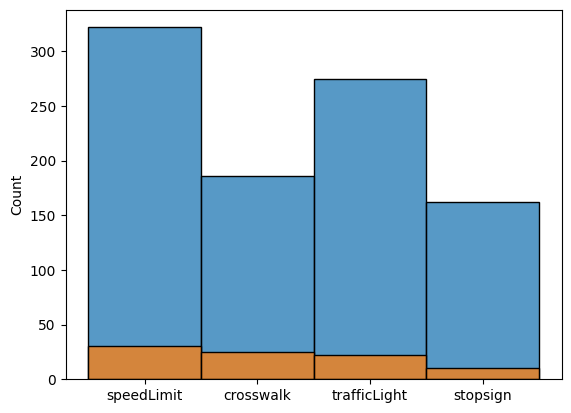

In [ ]:
sns.histplot([labelDict[i] for i in [ x for listT in trainTruths for x in listT]]),sns.histplot([labelDict[i] for i in [ x for listT in testTruths for x in listT]])

#Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import torchvision
import tensorflow as tf
from tensorflow import keras
import glob as gb
import torch
import torchvision
import math

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
bestValLoss=float('inf')
bestValMAP=0


In [ ]:
#hyperparameter search
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection import ssd
from torchvision.models.detection.ssdlite import ssdlite320_mobilenet_v3_large
ssdModel=ssdlite320_mobilenet_v3_large(num_classes=5, weights_backbone='IMAGENET1K_V1', trainable_backbone_layers=3,detections_per_img=100,topk_candidates=7,score_thresh=0.2,nms_thresh=0.55)

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer=torch.optim.Adam(ssdModel.parameters(), lr=0.0025)
epochs=30
ssdModel.to(device)
trainLosses=[]
valLosses=[]
for trainLayers in [0,1,2,3]:
  for lr in [0.1,0.15,0.2,0.3]:
    for detections in [40,100,150]:
      for topk in [3,7,12]:
        for score in [0.2,0.5,0.8]:
          for nms in [0.2,0.55,0.7]:
                ssdModel=ssdlite320_mobilenet_v3_large(num_classes=5, weights_backbone='IMAGENET1K_V1', trainable_backbone_layers=trainLayers,detections_per_img=detections,topk_candidates=topk,score_thresh=score,nms_thresh=nms)

                device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                optimizer=torch.optim.Adam(ssdModel.parameters(), lr=lr)
                epochs=80
                ssdModel.to(device)
                trainLosses=[]
                trainBBAccs=[]
                trainMAPs=[]
                valLosses=[]
                valBBAccs=[]
                valMAPs=[]
                bestValLossLocal=float('inf')
                bestValMAPLocal=0
                for epoch in range(epochs):
                    print("Epoch: "+str(epoch))
                    ssdModel.train()
                    trainLoss=0
                    trainBBAcc=0
                    for i, (imgsTrainBatch,vertsTrainBatch, truthsTrainBatch) in enumerate(roadTrainSetPrefetch):
                        trainMAP=MeanAveragePrecision('xyxy','bbox')
                        ssdModel.train()
                        vertsTrainBatch=torch.nested.nested_tensor(vertsTrainBatch.numpy().tolist(),layout=torch.jagged).to(device)
                        truthsTrainBatch=torch.nested.nested_tensor(truthsTrainBatch.numpy().tolist(),layout=torch.jagged).to(device)
                        imgsTrainBatch=torch.permute(torch.from_numpy(imgsTrainBatch.numpy()),(0,3,1,2)).to(device)
                        optimizer.zero_grad()
                        truths=[{"boxes":x,"labels":y.long()} for x,y in zip(vertsTrainBatch,truthsTrainBatch)]
                        outputs=ssdModel(imgsTrainBatch,truths)
                        loss=outputs['bbox_regression']+outputs['classification']
                        loss.backward()
                        optimizer.step()
                        trainLoss+=loss.item()
                        ssdModel.eval()
                        with torch.no_grad():
                          outputs=ssdModel(imgsTrainBatch,truths)
                        for y,output in enumerate(outputs):
                          BBAcc=torchvision.ops.box_iou(truths[y]["boxes"],outputs[y]['boxes']).mean().item()
                          trainBBAcc+= (BBAcc if math.isnan(BBAcc) is False else 0)/len(outputs)
                        truths=[{"boxes":x,"labels":y.long()-1} for x,y in zip(vertsTrainBatch,truthsTrainBatch)]
                        for output in outputs:
                          output['labels']=output['labels']-1
                        trainMAP.update(outputs,truths)
                        trainMAP=trainMAP.compute()['map']
                    trainLosses.append(trainLoss/(i+1))
                    trainBBAccs.append(trainBBAcc/(i+1))
                    trainMAPs.append(trainMAP)
                    ssdModel.train()
                    valLoss=0
                    valBBAcc=0
                    with torch.no_grad():
                      for j, (imgsValBatch,vertsValBatch, truthsValBatch) in enumerate(roadTestSetPrefetch):
                          valMAP=MeanAveragePrecision('xyxy','bbox')
                          ssdModel.train()
                          imgsValBatch=torch.permute(torch.from_numpy(imgsValBatch.numpy()),(0,3,1,2)).to(device)
                          vertsValBatch=torch.nested.nested_tensor(vertsValBatch.numpy().tolist(),layout=torch.jagged).to(device)
                          truthsValBatch=torch.nested.nested_tensor(truthsValBatch.numpy().tolist(),layout=torch.jagged).to(device)
                          truths=[{"boxes":x,"labels":y.long()} for x,y in zip(vertsValBatch,truthsValBatch)]
                          outputs=ssdModel(imgsValBatch,truths)
                          loss=outputs['bbox_regression']+outputs['classification']
                          valLoss+=loss.item()
                          ssdModel.eval()
                          with torch.no_grad():
                            outputs=ssdModel(imgsValBatch,truths)
                          for y,output in enumerate(outputs):
                            BBAcc=torchvision.ops.box_iou(truths[y]["boxes"],outputs[y]['boxes']).mean().item()
                            valBBAcc+= (BBAcc if math.isnan(BBAcc) is False else 0)/len(outputs)
                          truths=[{"boxes":x,"labels":y.long()-1} for x,y in zip(vertsValBatch,truthsValBatch)]
                          for output in outputs:
                            output['labels']=output['labels']-1
                          valMAP.update(outputs,truths)
                          valMAP=valMAP.compute()['map']
                      valLosses.append(valLoss/(j+1))
                      valBBAccs.append(valBBAcc/(j+1))
                      valMAPs.append(valMAP)
                      ssdModel.eval()
                    print("Train Loss: "+str(trainLoss/(i+1)))
                    print("Val Loss: "+str(valLoss/(j+1)))
                    print("Train BB Acc: "+str(trainBBAcc/(i+1)))
                    print("Val BB Acc: "+str(valBBAcc/(j+1)))
                    print("Train Class MAP: "+str(trainMAP))
                    print("Val Class MAP: "+str(valMAP))
                    if valMAP>bestValMAPLocal:
                        bestValMAPLocal=valMAP
                        torch.save(ssdModel.state_dict(), 'ssdModelBestLocal')
                        print("Local Best!!!"+str(lr)+" "+str(trainLayers))
                    if valMAP>bestValMAP:
                        bestValMAP=valMAP
                        torch.save(ssdModel.state_dict(), 'ssdModelBest')
                        print("Best!!!"+str(lr)+" "+str(trainLayers))
                    if epoch>20:
                      if valLosses[-10]<valLosses[-1]:
                        break
                    roadTrainSetPrefetch=roadTrainSet.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
                    roadTestSetPrefetch=roadTestSet.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
                plt.plot(trainLosses)
                plt.plot(valLosses)
                plt.title("Training and Validation Losses")
                plt.legend(['train','val'])
                plt.show()
                plt.plot(trainBBAccs)
                plt.plot(valBBAccs)
                plt.title("Training and Validation Bounding Box Accuracy (IoU)")
                plt.legend(['train','val'])
                plt.show()
                plt.plot(trainMAPs)
                plt.plot(valMAPs)
                plt.title("Training and Validation Mean Average Precision")
                plt.legend(['train','val'])
                plt.show()

Epoch: 0


KeyboardInterrupt: 

Epoch: 0
Train Loss: 13.46694020302065
Val Loss: 11.879496256510416
Train BB Acc: 0.0
Val BB Acc: 0.0
Train Class MAP: tensor(0.)
Val Class MAP: tensor(0.)
Epoch: 1
Train Loss: 10.25778995021697
Val Loss: 10.048845609029135
Train BB Acc: 0.0003790435050764392
Val BB Acc: 0.0
Train Class MAP: tensor(0.)
Val Class MAP: tensor(0.)
Epoch: 2
Train Loss: 8.630908043153825
Val Loss: 8.896001180013021
Train BB Acc: 0.0011565666044912031
Val BB Acc: 0.0
Train Class MAP: tensor(0.)
Val Class MAP: tensor(0.)
Epoch: 3
Train Loss: 7.656625455425631
Val Loss: 8.003361066182455
Train BB Acc: 0.0029486859037030125
Val BB Acc: 0.0
Train Class MAP: tensor(0.)
Val Class MAP: tensor(0.)
Epoch: 4
Train Loss: 6.78968483401883
Val Loss: 7.39427916208903
Train BB Acc: 0.003885695482453992
Val BB Acc: 0.0
Train Class MAP: tensor(0.)
Val Class MAP: tensor(0.)
Epoch: 5
Train Loss: 6.202787768456243
Val Loss: 7.156167825063069
Train BB Acc: 0.008047716680072968
Val BB Acc: 0.0
Train Class MAP: tensor(0.)
Val Clas

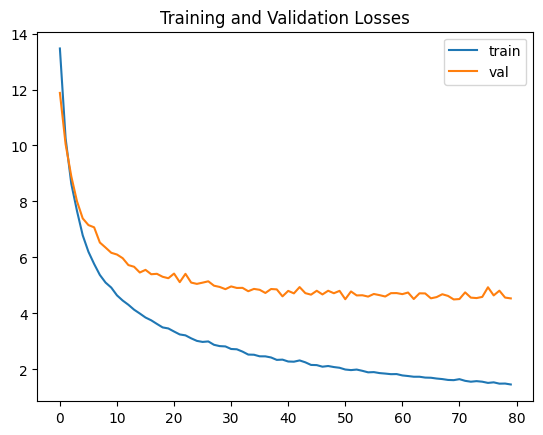

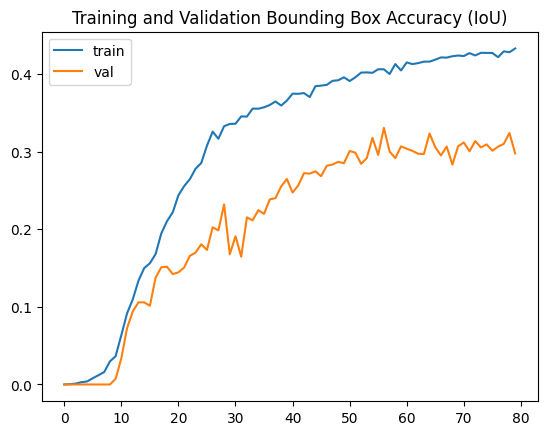

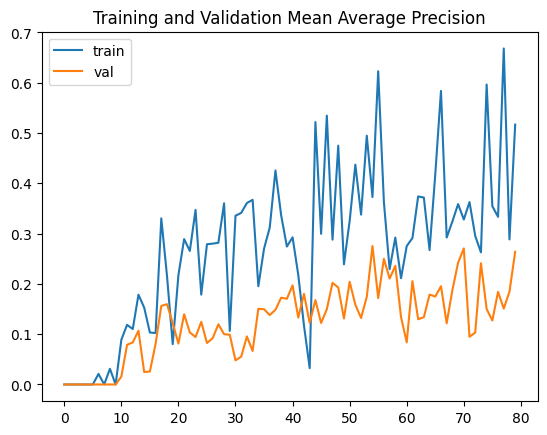

In [ ]:
#Additional hyperparamter tweaking of best found hyperparameters: trainLayers=3, lr=0.002, dectections_per_img=100, topk=7, score=0.8 nms=0.55
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection import ssd
from torchvision.models.detection.ssdlite import ssdlite320_mobilenet_v3_large
ssdModel=ssdlite320_mobilenet_v3_large(num_classes=5, weights_backbone='IMAGENET1K_V1', trainable_backbone_layers=0,detections_per_img=100,topk_candidates=7,score_thresh=0.8,nms_thresh=0.55, norm_layer=torch.nn.BatchNorm2d)
import torch

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer=torch.optim.Adam(ssdModel.parameters(), lr=0.0001)
epochs=80
ssdModel.to(device)
trainLosses=[]
trainBBAccs=[]
trainMAPs=[]
valLosses=[]
valBBAccs=[]
valMAPs=[]
bestValLossLocal=float('inf')
bestValMAPLocal=0
for epoch in range(epochs):
    print("Epoch: "+str(epoch))
    ssdModel.train()
    trainLoss=0
    trainBBAcc=0
    for i, (imgsTrainBatch,vertsTrainBatch, truthsTrainBatch) in enumerate(roadTrainSetPrefetch):
        trainMAP=MeanAveragePrecision('xyxy','bbox')
        ssdModel.train()
        vertsTrainBatch=torch.nested.nested_tensor(vertsTrainBatch.numpy().tolist(),layout=torch.jagged).to(device)
        truthsTrainBatch=torch.nested.nested_tensor(truthsTrainBatch.numpy().tolist(),layout=torch.jagged).to(device)
        imgsTrainBatch=torch.permute(torch.from_numpy(imgsTrainBatch.numpy()),(0,3,1,2)).to(device)
        optimizer.zero_grad()
        truths=[{"boxes":x,"labels":y.long()} for x,y in zip(vertsTrainBatch,truthsTrainBatch)]
        outputs=ssdModel(imgsTrainBatch,truths)
        loss=outputs['bbox_regression']+outputs['classification']
        loss.backward()
        optimizer.step()
        trainLoss+=loss.item()
        ssdModel.eval()
        with torch.no_grad():
          outputs=ssdModel(imgsTrainBatch,truths)
        for y,output in enumerate(outputs):
          BBAcc=torchvision.ops.box_iou(truths[y]["boxes"],outputs[y]['boxes']).mean().item()
          trainBBAcc+= (BBAcc if math.isnan(BBAcc) is False else 0)/len(outputs)
        truths=[{"boxes":x,"labels":y.long()-1} for x,y in zip(vertsTrainBatch,truthsTrainBatch)]
        for output in outputs:
          output['labels']=output['labels']-1
        trainMAP.update(outputs,truths)
        trainMAP=trainMAP.compute()['map']
    trainLosses.append(trainLoss/(i+1))
    trainBBAccs.append(trainBBAcc/(i+1))
    trainMAPs.append(trainMAP)
    ssdModel.train()
    valLoss=0
    valBBAcc=0
    with torch.no_grad():
      for j, (imgsValBatch,vertsValBatch, truthsValBatch) in enumerate(roadTestSetPrefetch):
          valMAP=MeanAveragePrecision('xyxy','bbox')
          ssdModel.train()
          imgsValBatch=torch.permute(torch.from_numpy(imgsValBatch.numpy()),(0,3,1,2)).to(device)
          vertsValBatch=torch.nested.nested_tensor(vertsValBatch.numpy().tolist(),layout=torch.jagged).to(device)
          truthsValBatch=torch.nested.nested_tensor(truthsValBatch.numpy().tolist(),layout=torch.jagged).to(device)
          truths=[{"boxes":x,"labels":y.long()} for x,y in zip(vertsValBatch,truthsValBatch)]
          outputs=ssdModel(imgsValBatch,truths)
          loss=outputs['bbox_regression']+outputs['classification']
          valLoss+=loss.item()
          ssdModel.eval()
          with torch.no_grad():
            outputs=ssdModel(imgsValBatch,truths)
          for y,output in enumerate(outputs):
            BBAcc=torchvision.ops.box_iou(truths[y]["boxes"],outputs[y]['boxes']).mean().item()
            valBBAcc+= (BBAcc if math.isnan(BBAcc) is False else 0)/len(outputs)
          truths=[{"boxes":x,"labels":y.long()-1} for x,y in zip(vertsValBatch,truthsValBatch)]
          for output in outputs:
            output['labels']=output['labels']-1
          valMAP.update(outputs,truths)
          valMAP=valMAP.compute()['map']
      valLosses.append(valLoss/(j+1))
      valBBAccs.append(valBBAcc/(j+1))
      valMAPs.append(valMAP)
      ssdModel.eval()
    print("Train Loss: "+str(trainLoss/(i+1)))
    print("Val Loss: "+str(valLoss/(j+1)))
    print("Train BB Acc: "+str(trainBBAcc/(i+1)))
    print("Val BB Acc: "+str(valBBAcc/(j+1)))
    print("Train Class MAP: "+str(trainMAP))
    print("Val Class MAP: "+str(valMAP))
    if valMAP>bestValMAPLocal:
        bestValMAPLocal=valMAP
        torch.save(ssdModel.state_dict(), 'ssdModelBestLocal')
    if valMAP>bestValMAP:
        bestValMAP=valMAP
        torch.save(ssdModel.state_dict(), 'ssdModelBest')
    if(valLoss<bestValLoss):
      bestValLoss=valLoss
      torch.save(ssdModel.state_dict(), 'ssdModelBestValLoss')
    roadTrainSetPrefetch=roadTrainSet.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    roadTestSetPrefetch=roadTestSet.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
plt.plot(trainLosses)
plt.plot(valLosses)
plt.title("Training and Validation Losses")
plt.legend(['train','val'])
plt.show()
plt.plot(trainBBAccs)
plt.plot(valBBAccs)
plt.title("Training and Validation Bounding Box Accuracy (IoU)")
plt.legend(['train','val'])
plt.show()
plt.plot(trainMAPs)
plt.plot(valMAPs)
plt.title("Training and Validation Mean Average Precision")
plt.legend(['train','val'])
plt.show()

In [ ]:
labelDict={1:'crosswalk',2:'speedLimit',3:'stopsign',4:'trafficLight'}

In [ ]:
import cv2

def draw_boxes(boxes,labels,image):
    roadLabelDict={1:'crosswalk',2:'speed',3:'stopsign',4:'trafficLight'}
    image=cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
    for i,box in enumerate(boxes):
        cv2.rectangle(image,(int(box[0]), int(box[1])),(int(box[2]),int(box[3])),color=(0,255,0))
        cv2.putText(image,str(roadLabelDict[labels[i]]),(int(box[0]), int(box[1]-5)),cv2.FONT_HERSHEY_SIMPLEX,0.4,(0,255,0),1,lineType=cv2.LINE_AA)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    for i, box in enumerate(boxes):
      plt.plot((box[0]+box[2])/2,(box[1]+box[3])/2, marker='o', color='red', markersize=5)

tensor([[0.6236, 0.3500, 0.4095, 0.0000],
        [0.0632, 0.0000, 0.2154, 0.0000]]) tensor(0.1515)


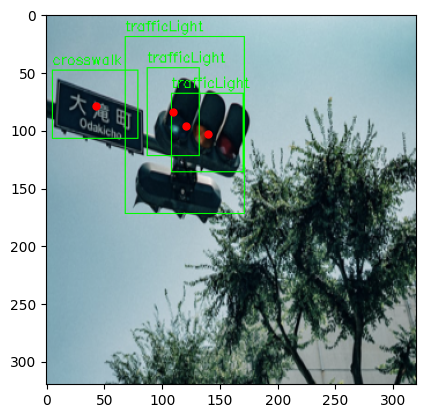

In [ ]:
#object detection performance test on validation set
MAP=MeanAveragePrecision('xyxy','bbox')
ssdModel=ssdlite320_mobilenet_v3_large(num_classes=5, weights_backbone='IMAGENET1K_V1', trainable_backbone_layers=3,detections_per_img=100,topk_candidates=3,score_thresh=0.3,nms_thresh=0.45)
ssdModel.load_state_dict(torch.load('/content/drive/MyDrive/itcs5154/models/ssdModelBestValLoss',weights_only=True))
ssdModel.eval()
with torch.no_grad():
  for (imgValBatch, vertsValBatch, truthsValBatch) in roadTestSetPrefetch.take(1):
    imgValBatch=torch.permute(torch.from_numpy(imgValBatch.numpy()),(0,3,1,2))
    outputs=ssdModel(imgValBatch[0:1])
    vertsValBatch=torch.nested.nested_tensor(vertsValBatch.numpy().tolist(),layout=torch.jagged)
    truthsValBatch=torch.nested.nested_tensor(truthsValBatch.numpy().tolist(),layout=torch.jagged)
    truths=[{"boxes":x,"labels":y.long()-1} for x,y in zip(vertsValBatch,truthsValBatch)]
  draw_boxes(outputs[0]['boxes'].detach().numpy(),outputs[0]['labels'].detach().numpy(),torch.permute(imgValBatch[0],(1,2,0)))
  outputs[0]['labels']=outputs[0]['labels']-1
  MAP.update(outputs,truths[0:1])
  MAP=MAP.compute()['map']
  print(torchvision.ops.box_iou(torch.from_numpy(vertsValBatch[0].numpy()),torch.from_numpy(outputs[0]['boxes'].detach().numpy())), MAP)


In [ ]:
outputs[0]['scores']

tensor([0.8155, 0.2748, 0.1530, 0.1523, 0.0826, 0.0700, 0.0663])

#Google Street View Testing

In [ ]:
!pip install google-streetview

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for google-streetview: filename=google_streetview-1.2.9-py3-none-any.whl size=9777 sha256=380ed1105b4360b5a5a153aa3021498d739f4b7a177f697ac95092fe28abb670
  Stored in directory: /root/.cache/pip/wheels/8f/55/d0/074e47d0e3fede14e60ddcd7b1a59681e1f1c3fd5b56cef79d
  Created wheel for kwconfig: filename=kwconfig-1.1.7-py3-none-any.whl size=4974 sha256=bfe437bd45e788fd8ffa86156a2c251dfa8ddd032d7874bc166c19a6740853b2
  Stored in directory: /root/.cache/pip/wheels/5d/ae/f3/4f084ead544ae0187acf5ef586c5ee24ec92e1029b3383a8ac
Successfully built google-streetview kwconfig


In [ ]:
import math
import pyproj
import cv2
import os
import matplotlib.pyplot as plt
import urllib
from google.colab import drive
drive.mount('/content/drive/')
#GSV photogrammetry methods

def getGSVImage(lat,lon,heading,pitch,location=None,path="/content/drive/MyDrive/itcs5154/GoogleStreetViewImagery/"):
  #based off of https://andrewpwheeler.com/2015/12/28/using-python-to-grab-google-street-view-imagery/
  if location:
    location=urllib.parse.quote_plus(location)
  else:
    location=urllib.parse.quote_plus(str(lat)+","+str(lon))
  url="https://maps.googleapis.com/maps/api/streetview?size=1200x800&location="+location+"&heading="+str(heading)+"&tilt="+str(pitch)+"&key=<Insert Google Street View API key>"
  urllib.request.urlretrieve(url,os.path.join(path,location+'.jpg'))
  image=cv2.imread(os.path.join(path,location+'.jpg'))
  return cv2.cvtColor(image,cv2.COLOR_BGR2RGB),path+location+'.jpg'

def getDetectionOffset(img,box):
  imgCenter=img.shape[1]/2,img.shape[0]/2
  boxCenter=(box[0]+box[2])/2,(box[1]+box[3])/2
  return boxCenter[0]-imgCenter[0],boxCenter[1]-imgCenter[1]

def getDetectionCoords(img,box,bearing,lon,lat):
  projection=pyproj.CRS.from_epsg(3857)
  coordsToIngs=pyproj.Transformer.from_crs(projection.geodetic_crs,projection,True,allow_ballpark=False)
  ingsToCoords=pyproj.Transformer.from_crs(projection,projection.geodetic_crs,True,allow_ballpark=False)
  offset=getDetectionOffset(img[0],box)
  offsetX=offset[0]*0.0088
  offsetY=offset[1]*0.0088
  print('Image center offset(mm): '+str(offsetX)+" "+str(offsetX))
  signBearing=math.atan(offset[0]/5.1)+math.radians(bearing)
  print('Sign Bearing(rads): '+str(signBearing))
  signHeightPixels=abs(box[1]-box[3])
  range=5.1*((0.762)/(signHeightPixels*0.0088))
  print('Range(m): '+str(range))
  easting,northing=coordsToIngs.transform(lon,lat)
  print("Easting, Northing (m): "+str(easting)+" "+str(northing))
  signEasting,signNorthing=(easting+range*math.sin(signBearing)),(northing+range*math.cos(signBearing))
  print("Sign Easting, Sign Northing (m): "+str(signEasting)+" "+str(signNorthing))
  return ingsToCoords.transform(signEasting,signNorthing)




Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Image center offset(mm): 3.8368 3.8368
Sign Bearing(rads): 5.370200567193827
Range(m): 2.944090909090909
Easting, Northing (m): 4025107.2133811247 -15419028.870609159
Sign Easting, Sign Northing (m): 4025104.8836275074 -15419027.070631558

coords xy: (36.158132371467175, -79.81156853984653)
error: -2.0928532826758328e-05 , 2.860153472283855e-06
error in meters(-2.3297536173250473, 0.31839082812525216)
coords yx: -79.81156853984653,36.158132371467175
-----------------------------------------


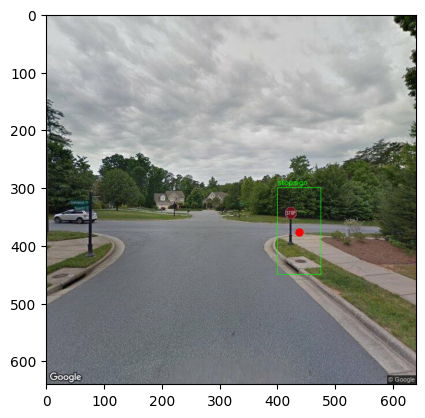

In [ ]:
#manual box testing for photogrammetry accuracy
coords=getDetectionCoords(img[0],[400,300,475,450],218.36,36.1581533,-79.8115714)
draw_boxes(np.array([[400,300,475,450]]),np.array([3]),img[0])
coordsToIngs=pyproj.Transformer.from_crs(pyproj.CRS.from_epsg(3857).geodetic_crs,pyproj.CRS.from_epsg(3857),True,allow_ballpark=False)
print('')
print('coords xy: '+ str(coords))
print('error: '+str(coords[0]-(36.1581533))+' , '+str(coords[1]-(-79.8115714)))
print('error in meters'+str(coordsToIngs.transform(coords[0]-(36.1581533),coords[1]-(-79.8115714))))
print('coords yx: '+str(coords[1])+','+str(coords[0]))
print("-----------------------------------------")

Image center offset(mm): 2.815241 2.815241
Sign Bearing(rads): 5.365956835245731
Range(m): 0.7416649
Easting, Northing (m): 4025107.2133811247 -15419028.870609159
Sign Easting, Sign Northing (m): 4025106.8 -15419029.0

coords xy: (36.15814913737653, -79.81157160560123)
error: -4.162623469028404e-06 , -2.0560122493407107e-07
error in meters(-0.46338112493637185, -0.022887423666134093)
coords yx: -79.81157160560123,36.15814913737653
-----------------------------------------


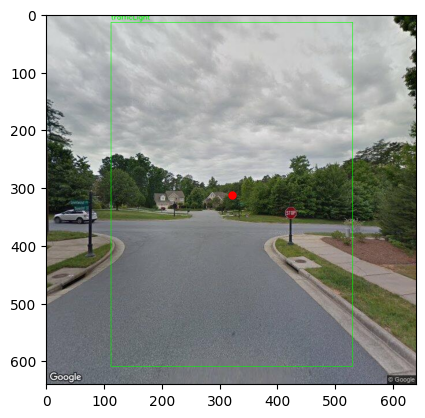

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torchvision.models.detection import ssd
from torchvision.models.detection.ssdlite import ssdlite320_mobilenet_v3_large
img=getGSVImage(36.1581533,-79.8115714,218.36,'0')
ssdModel=ssdlite320_mobilenet_v3_large(num_classes=5, weights_backbone='IMAGENET1K_V1', trainable_backbone_layers=3,detections_per_img=100,topk_candidates=7,score_thresh=0.1,nms_thresh=0.55)
ssdModel.load_state_dict(torch.load('/content/drive/MyDrive/itcs5154/models/ssdModelBestValLoss',map_location=torch.device('cpu'),weights_only=True))
with torch.no_grad():
  ssdModel.eval()
  outputs=ssdModel([torch.permute(torch.Tensor(img[0]),(2,0,1))])
  draw_boxes(outputs[0]['boxes'].detach().numpy(),outputs[0]['labels'].detach().numpy(),img[0])

coords=getDetectionCoords(img[0],outputs[0]['boxes'][0].detach().numpy(),218.36,36.1581533,-79.8115714)

coordsToIngs=pyproj.Transformer.from_crs(pyproj.CRS.from_epsg(3857).geodetic_crs,pyproj.CRS.from_epsg(3857),True,allow_ballpark=False)
print('')
print('coords xy: '+ str(coords))
print('error: '+str(coords[0]-(36.1581533))+' , '+str(coords[1]-(-79.8115714)))
print('error in meters'+str(coordsToIngs.transform(coords[0]-(36.1581533),coords[1]-(-79.8115714))))
print('coords yx: '+str(coords[1])+','+str(coords[0]))
print("-----------------------------------------")

In [ ]:
outputs[0]['scores']

tensor([0.1056, 0.1043])

In [ ]:
[labelDict[x.item()] for x in outputs[0]['labels']]

['stopsign', 'trafficLight']

In [ ]:
GSVCoordTestList={'gsvImgLoc': [[-79.8115714,36.1581533,218.36],[-79.8218482,36.1365449,232.81],[-111.8900698,33.3317123,67.89],[-103.2846119,47.8010955,349.72],[-73.8365689,40.915994,3.09],[-91.4056575,33.5851385,358.34]],
                  'signLoc': [[-79.81169665107663,36.15808588721798],[-79.82194237441456,36.13651275457157],[-111.88987962679874,33.33167375599998],[-103.28456595654461,47.801202999707975],[-73.83660577770422,40.916089615012964],[-91.40557917156397,33.58544947002563]]}

errors=[]

coordsToIngs=pyproj.Transformer.from_crs(pyproj.CRS.from_epsg(3857).geodetic_crs,pyproj.CRS.from_epsg(3857),True,allow_ballpark=False)
for gsv,truth in zip(GSVCoordTestList['gsvImgLoc'],GSVCoordTestList['signLoc']):
  img=getGSVImage(gsv[1],gsv[0],gsv[2],'0')
  outputs=ssdModel([torch.permute(torch.Tensor(img[0]),(2,0,1))])
  for box in outputs[0]['boxes']:
    coords=getDetectionCoords(img[0],box.detach().numpy(),gsv[2],gsv[0],gsv[1])
    error=(coords[0]-truth[0],coords[1]-truth[1])
    errors.append(error)
    print('')
    print('coords xy: '+ str(coords))
    print('error: '+str(coords[0]-(truth[0]))+' , '+str(coords[1]-(truth[1])))
    print('coords yx: '+str(coords[1])+','+str(coords[0]))
    print("-----------------------------------------")
meanError=np.array(errors).mean(axis=0)
print("Average Coordinate Error Lon/Lat: "+str(meanError))
print("Average Coordinate Error in meters:"+str(coordsToIngs.transform(meanError[0],meanError[1])))

Image center offset(mm): 2.815241 2.815241
Sign Bearing(rads): 5.365956835245731
Range(m): 0.7416649
Easting, Northing (m): -8884583.487658996 4322404.900342502
Sign Easting, Sign Northing (m): -8884584.0 4322405.5

coords xy: (-79.81157600243753, 36.15815764926824)
error: 0.00012064863909699852 , 7.176205026127036e-05
coords yx: 36.15815764926824,-79.81157600243753
-----------------------------------------
Image center offset(mm): 2.7486413 2.7486413
Sign Bearing(rads): 2.739373740625524
Range(m): 1.2881641
Easting, Northing (m): -12455545.594959838 3939416.4473659154
Sign Easting, Sign Northing (m): -12455545.0 3939415.2

coords xy: (-111.89006445538485, 33.331703313224295)
error: -0.00018482858610013864 , 2.95572243160791e-05
coords yx: 33.331703313224295,-111.89006445538485
-----------------------------------------
Image center offset(mm): 3.9367356 3.9367356
Sign Bearing(rads): 2.744300541592711
Range(m): 1.2883316
Easting, Northing (m): -12455545.594959838 3939416.4473659154
Sign